In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from glob import glob
from tqdm import tqdm
from copy import deepcopy
import pickle
from cifar10_utils import get_cifar10, get_dataloader

from models_v2 import (BasicCNN, AutoencoderCNN, ECACNN, AutoencoderECACNN,
                       ECASpatialCNN, DeeperCNN, LinearAutoencoderECACNN, CBAMCNN)


In [2]:
# Seed for reproduceability
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
print(device)

cpu


In [3]:
# Grad-CAM: for more info https://jacobgil.github.io/pytorch-gradcam-book/introduction.html
%pip install grad-cam --quiet
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
cifar10 = get_cifar10()
cifar10_loader = get_dataloader(cifar10, 128)

100%|██████████| 170498071/170498071 [00:02<00:00, 79607734.96it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
def make_plots(logging_dict, model_name, avg_train=True):
#     logging_dict = {'loss': {'train': [], 'validation': []},
#                 'accuracy': {'train': [], 'validation': []},
#                 'lr': [],
#                 'batches_per_epoch': [],}
    epoch_ends = np.cumsum(logging_dict['batches_per_epoch'])

    def get_avg_per_epoch(batch_data):
        result = [None,]
        for i in range(len(epoch_ends) - 1):
            result.append(np.average(batch_data[epoch_ends[i]:epoch_ends[i + 1]]))
        return result

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    metrics = ('loss', 'accuracy')
    for metric, ax in zip(metrics, axes.ravel()):
#         ax.plot(logging_dict[metric]['train'])
        if avg_train:
            ax.plot(get_avg_per_epoch(logging_dict[metric]['train']), '.-', label='training set')
            ax.plot(logging_dict[metric]['validation'], '.-', label='validation set')
            ax.set(title=metric, xlabel='epoch', xticks=np.arange(len(epoch_ends)))
        else:
            ax.plot(logging_dict[metric]['train'],'.-', label='training set')
            ax.plot(epoch_ends, logging_dict[metric]['validation'],'.-', label='validation set')
            ax.set(title=metric, xlabel='batch')

    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

In [6]:
for file in glob('../input/models-data/models/*/*'):
    print(file)

../input/models-data/models/autoencoder/autoencoder.pkl
../input/models-data/models/autoencoder/autoencoder.pt
../input/models-data/models/cnn/cnn.pt
../input/models-data/models/cnn/cnn.pkl
../input/models-data/models/linear_autoencoder_eca/linear_autoencoder_eca.pt
../input/models-data/models/linear_autoencoder_eca/linear_autoencoder_eca.pkl
../input/models-data/models/eca/eca.pkl
../input/models-data/models/eca/eca.pt
../input/models-data/models/deeper_cnn/deeper_cnn.pkl
../input/models-data/models/deeper_cnn/deeper_cnn.pt
../input/models-data/models/cbam/cbam.pkl
../input/models-data/models/cbam/cbam.pt
../input/models-data/models/eca_spatial/eca_spatial.pkl
../input/models-data/models/eca_spatial/eca_spatial.pt
../input/models-data/models/autoencoder_eca/autoencoder_eca.pt
../input/models-data/models/autoencoder_eca/autoencoder_eca.pkl


In [7]:
cnn_model = BasicCNN().to(device)
autoencoder_model = AutoencoderCNN().to(device)
eca_model = ECACNN().to(device)
autoencoder_eca_model = AutoencoderECACNN().to(device)
eca_spatial_model = ECASpatialCNN().to(device)
deeper_cnn_model = DeeperCNN().to(device)
linear_autoencoder_model = LinearAutoencoderECACNN().to(device)
cbam_model = CBAMCNN().to(device)


In [8]:
models = {'cnn': {'instance': cnn_model, 'data': None},
          'eca': {'instance': eca_model, 'data': None},
          'cbam': {'instance': cbam_model, 'data': None},
          'autoencoder': {'instance': autoencoder_model, 'data': None},
          'autoencoder_eca': {'instance': autoencoder_eca_model, 'data': None},
          'linear_autoencoder_eca': {'instance': linear_autoencoder_model, 'data': None},
          'eca_spatial': {'instance': eca_spatial_model, 'data': None},
          'deeper_cnn': {'instance': deeper_cnn_model, 'data': None},
}


for name, model in models.items():
    model['instance'].load_state_dict(torch.load(f'../input/models-data/models/{name}/{name}.pt', map_location=torch.device(device)))
    with open(f'../input/models-data/models/{name}/{name}.pkl', 'rb') as f:
        model['data'] = pickle.load(f)

---

# Grad-CAM Visualizations

In [26]:
classes_names = {i: c for i, c in enumerate (('airplane', 'automobile', 'bird', 'cat', 'deer',
                                              'dog', 'frog', 'horse', 'ship', 'truck',))}
def compare_activations(models_dict: dict, target_layers, image_number=None, dataset=cifar10['train'], use_cuda=use_cuda):
    '''
    Compare gradcam visualizations of differenct models.
    If image_number is None, a random image will be selected.
    '''
    fig, axs = plt.subplots(1, len(models) + 1, figsize=(16, 3))
    if image_number == None:
        image_number = np.random.randint(len(dataset))
    img, label = cifar10['train'][image_number]
        
    def normalize(img):
        return ((img - img.min()) / (img.max() - img.min()))
    
    def inverse_normalize(img):
        invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
        return invTrans(img)

    
    # Show original image
    axs = axs.ravel()
    axs[0].imshow(torch.permute(inverse_normalize(img), (1, 2, 0)))
    axs[0].axis('off')
    axs[0].set(title='Original Image')
    
    # Show activations for each model
    for i, (model, ax) in enumerate(zip(models_dict.items(), axs[1:])):
        model_name = model[0]
        model_instance = model[1]['instance']
#         target_layer = [model_instance.get_submodule(target_layers[model_name])]
        target_layer = [model_instance.get_submodule('layer2')]

        model_instance.eval()
        input_tensor = img.unsqueeze(0).to(device)       
        cam = GradCAM(model=model_instance, target_layers=target_layer, use_cuda=use_cuda)
        targets = [ClassifierOutputTarget(label)]
        targets= None
        grayscale_cam = cam(input_tensor, targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(normalize(torch.permute(img, (1, 2, 0))).numpy(), grayscale_cam, use_rgb=True)
        ax.imshow(visualization)
        ax.axis('off')
        ax.set(title=f'{model_name}')
        
        # Display classifiction results
        
        with torch.no_grad():
            probabilities = model_instance(input_tensor)
        results = [(classes_names[index], prob) for index, prob in enumerate(probabilities.squeeze(0))]
        results_sorted = sorted(results, key=lambda item: item[1], reverse=True)
        results_text = '\n'.join([f'{res[0]} ({res[1].item():.2f})' for res in results_sorted[:3]])
        ax.annotate(results_text, (0.5, -0.1), (0, 0), xycoords='axes fraction', textcoords='offset points', va='top', ha='center');
    
    plt.suptitle(f'{classes_names[label]} ({label}) (image {image_number})')
    plt.tight_layout()
    plt.show()

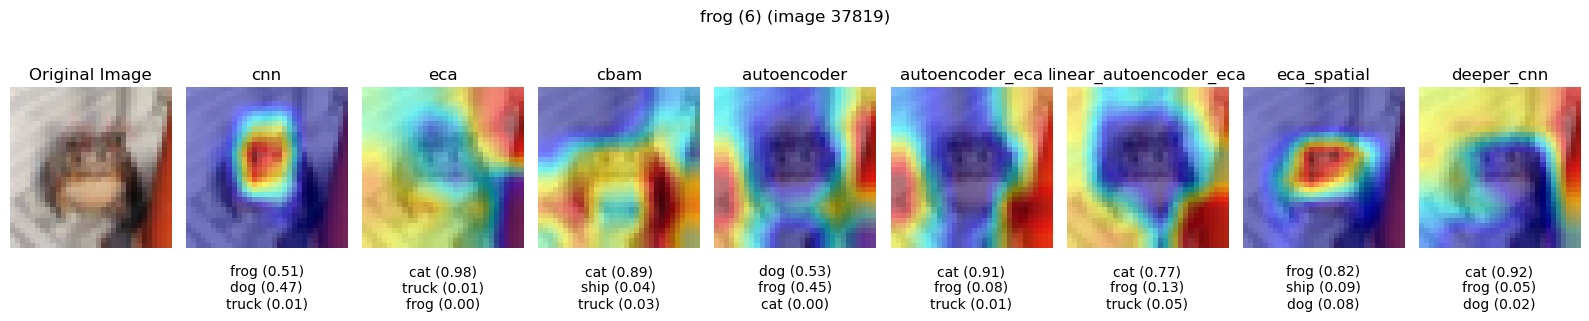

In [53]:
compare_activations(models_dict=models, target_layers='layer2.conv2', dataset=cifar10['train'])

good:
* 2612
* 44974
* 14541
* 19457
* 26557
* 33763
* 39504
* 38660
* 38158
* 6265
* 4658
* 16023
* 1685

same:
* 1021
* 11653
* 43573
* 13417
* 9692

bad:
* 5675
* 16850
* 37194
* 41090
* 37819

meh:
* 3561
* 21962



In [ ]:
# def topk_accuracy(output, target, topk=(1, 3)):
#     """Computes the accuracy over the k top predictions for the specified values of k"""
#     with torch.no_grad():
#         maxk = max(topk)
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         correct = pred.eq(target.view(1, -1).expand_as(pred))

#         res = []
#         for k in topk:
#             correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#             res.append(correct_k.mul_(100.0 / batch_size))
#         return res
    

# Results analysis

In [ ]:
# dict_keys(['test_accuracy', 'test_loss', 'logging_dict', 'datetime'])
# dict_keys(['loss', 'accuracy', 'lr', 'batches_per_epoch', 'momentum'])

In [47]:
for name, model in models.items():
    data = model['data']
    logs = data['logging_dict']
test_accuracies = [(name, model['data']['test_accuracy']) for name, model in models.items()]
best_validation_accuracies = [(name,
                               np.max(model['data']['logging_dict']['accuracy']['validation']))
                              for name, model in models.items()]
best_train_accuracy = [(name,
                        np.max(model['data']['logging_dict']['accuracy']['train']))
                        for name, model in models.items()]
best_train_accuracy
#     make_plots(logs, name)

[('cnn', 0.8984375),
 ('eca', 0.8984375),
 ('cbam', 0.8515625),
 ('autoencoder', 0.890625),
 ('autoencoder_eca', 0.9140625),
 ('linear_autoencoder_eca', 0.890625),
 ('eca_spatial', 0.890625),
 ('deeper_cnn', 0.875)]